#  **Portfolio Optimisation with LLM-Derived Risk Scores**
This notebook demonstrates optimisation-based portfolio allocation where traditional expected returns are replaced by LLM-derived weighted risk scores. The objective is to minimise portfolio variance while maintaining strong risk-adjusted expected returns, following Modern Portfolio Theory (MPT) principles.

**Key Features:**
- Analyse five major stocks: AAPL, GOOGL, MSFT, AMZN, TSLA
- Replace financial expected returns with document-derived weighted LLM risk scores
- Compute portfolio variance and optimise allocations under diversification constraints
- Produce structured audit-ready outputs for compliance tracking

## Step 1: Import Libraries
Import required Python libraries for data retrieval, numerical computation, optimisation, plotting, and LLM inference.

In [81]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from transformers import pipeline
from typing import Dict

## Step 2: Define Tickers and Download Financial Data
Select five major stocks and download historical price data from Yahoo Finance.

In [82]:
tickers = ['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'TSLA']
start_date = '2020-01-01'
end_date = '2022-01-01'

data = yf.download(
    tickers,
    start=start_date,
    end=end_date,
    auto_adjust=True,  # Adjusted closes are now in 'Close'
    interval='1d'
)

if data.empty:
    raise ValueError("Downloaded data is empty. Check tickers and date range.")

[*********************100%***********************]  5 of 5 completed


## Step 3: Compute Daily Returns and Covariance Matrix
Compute daily percentage returns and covariance matrix. The covariance matrix will be used to calculate portfolio variance.

In [83]:
# Use Close (already adjusted)
adj_close = data['Close']
daily_returns = adj_close.pct_change().dropna()
cov_matrix = daily_returns.cov()

print("Adjusted Close Head:\n", adj_close.head())
print("Covariance Matrix:\n", cov_matrix)

Adjusted Close Head:
 Ticker           AAPL       AMZN      GOOGL        MSFT       TSLA
Date                                                              
2020-01-02  72.468277  94.900497  67.920815  152.505722  28.684000
2020-01-03  71.763725  93.748497  67.565506  150.606705  29.534000
2020-01-06  72.335548  95.143997  69.366394  150.996033  30.102667
2020-01-07  71.995346  95.343002  69.232407  149.619263  31.270666
2020-01-08  73.153503  94.598503  69.725174  152.002487  32.809334
Covariance Matrix:
 Ticker      AAPL      AMZN     GOOGL      MSFT      TSLA
Ticker                                                  
AAPL    0.000557  0.000320  0.000334  0.000412  0.000516
AMZN    0.000320  0.000410  0.000266  0.000305  0.000403
GOOGL   0.000334  0.000266  0.000411  0.000361  0.000380
MSFT    0.000412  0.000305  0.000361  0.000470  0.000484
TSLA    0.000516  0.000403  0.000380  0.000484  0.002194


## Step 4: Generate LLM-Derived Risk Scores
Use a language model to simulate risk scores for each stock based on hypothetical documents or risk factors. Scores are scaled between 0 and 1.

In [84]:
llm_pipeline = pipeline('text-classification', model='distilbert-base-uncased-finetuned-sst-2-english')

documents = {
    'AAPL': 'Apple faces moderate supply chain risk but has stable revenues.',
    'GOOGL': 'Google faces potential regulatory scrutiny in multiple regions.',
    'MSFT': 'Microsoft has strong cloud revenue but some cybersecurity exposure.',
    'AMZN': 'Amazon logistics face risks from rising fuel costs.',
    'TSLA': 'Tesla production is volatile due to new factory setups.'
}

def compute_risk_scores(documents: Dict[str, str], llm_pipeline) -> Dict[str, float]:
    """
    Convert LLM text outputs to numeric risk scores between 0 (low risk) and 1 (high risk)
    """
    scores = {}
    for ticker, text in documents.items():
        result = llm_pipeline(text)[0]
        # Map positive sentiment → low risk, negative → high risk
        score = 1 - result['score'] if result['label'] == 'POSITIVE' else result['score']
        scores[ticker] = score
    return scores

risk_scores = compute_risk_scores(documents, llm_pipeline)
expected_returns = np.array([risk_scores[t] for t in tickers])


Device set to use cpu


## Step 5: Define Portfolio Variance Function
This function calculates the total portfolio variance given a set of weights and the covariance matrix.

In [85]:
def compute_portfolio_variance(weights: np.ndarray, cov_matrix: np.ndarray) -> float:
    """
    Compute total portfolio variance given weights and covariance matrix.
    """
    return weights.T @ cov_matrix @ weights

## Step 6: Define Constraints and Bounds
Ensure portfolio weights sum to 1 and enforce a minimum allocation of 5% per stock for diversification.

In [86]:
min_allocation = 0.05  # Minimum 5% per stock

def weight_constraint(weights: np.ndarray) -> float:
    """Ensure weights sum to 1"""
    return np.sum(weights) - 1

bounds = [(min_allocation, 1.0) for _ in tickers]
initial_weights = np.random.dirichlet(np.ones(len(tickers)))

constraints = [{'type': 'eq', 'fun': weight_constraint}]

## Step 7: Optimise Portfolio Weights
Use `scipy.optimize.minimize` to find weights that minimise portfolio variance under constraints.

In [87]:
result = minimize(
    compute_portfolio_variance,
    initial_weights,
    args=(cov_matrix,),
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)

if not result.success:
    raise ValueError("Optimisation failed:", result.message)

optimized_weights = result.x

## Step 8: Calculate Portfolio Return and Risk
Compute the portfolio's expected return (LLM risk score average) and variance.

In [88]:
portfolio_return = np.dot(expected_returns, optimized_weights)
portfolio_variance_value = compute_portfolio_variance(optimized_weights, cov_matrix)
portfolio_std = np.sqrt(portfolio_variance_value)
portfolio_sharpe = None  # placeholder, use real backtest Sharpe later

## Step 8B: Backtest Portfolio Performance with OOS Metrics

=== Full Period Metrics ===
Total Return: 140.00%
Annualised Return: 70.00%
Annualised Volatility: 30.98%
Sharpe Ratio: 2.26
Max Drawdown: -27.59%

=== Out-of-Sample (OOS) Metrics ===
Total Return: 12.97%
Annualised Return: 32.37%
Annualised Volatility: 18.77%
Sharpe Ratio: 1.72
Max Drawdown: -7.05%


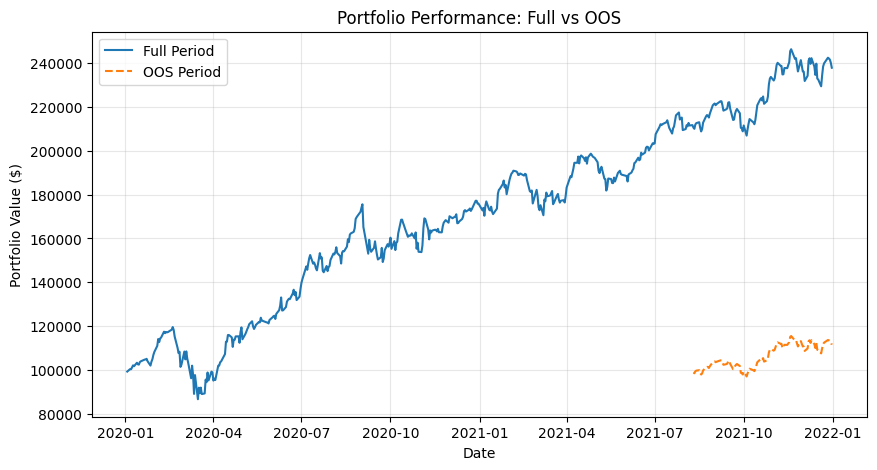

In [89]:
initial_capital = 100000  # $100k starting capital

# Split data: 80% in-sample (training), 20% out-of-sample (testing)
split_idx = int(0.8 * len(daily_returns))
train_returns = daily_returns.iloc[:split_idx]
test_returns = daily_returns.iloc[split_idx:]

def backtest_portfolio(weights, returns, initial_capital=100000):
    capital = initial_capital
    portfolio_values = []
    for i in range(len(returns)):
        daily_ret = returns.iloc[i].values
        daily_portfolio_ret = np.dot(weights, daily_ret)
        capital *= (1 + daily_portfolio_ret)
        portfolio_values.append(capital)
    return pd.Series(portfolio_values, index=returns.index)

# Backtest on full period
portfolio_series_full = backtest_portfolio(optimized_weights, daily_returns, initial_capital)

# Backtest OOS (last 20%)
portfolio_series_oos = backtest_portfolio(optimized_weights, test_returns, portfolio_series_full.iloc[0])

# Metrics function (simpler, no daily_returns needed)
def portfolio_metrics(portfolio_series):
    total_return = (portfolio_series.iloc[-1] / portfolio_series.iloc[0]) - 1
    annualised_return = total_return / (len(portfolio_series)/252)
    annualised_vol = portfolio_series.pct_change().std() * np.sqrt(252)
    sharpe_ratio = annualised_return / annualised_vol

    # Max Drawdown
    rolling_max = portfolio_series.cummax()
    drawdown = (portfolio_series - rolling_max) / rolling_max
    max_drawdown = drawdown.min()

    return total_return, annualised_return, annualised_vol, sharpe_ratio, max_drawdown

# Compute metrics using only portfolio_series
full_metrics = portfolio_metrics(portfolio_series_full)
oos_metrics = portfolio_metrics(portfolio_series_oos)

# Update Step 8 Sharpe
portfolio_sharpe = full_metrics[3]

print("=== Full Period Metrics ===")
print(f"Total Return: {full_metrics[0]:.2%}")
print(f"Annualised Return: {full_metrics[1]:.2%}")
print(f"Annualised Volatility: {full_metrics[2]:.2%}")
print(f"Sharpe Ratio: {full_metrics[3]:.2f}")
print(f"Max Drawdown: {full_metrics[4]:.2%}")

print("\n=== Out-of-Sample (OOS) Metrics ===")
print(f"Total Return: {oos_metrics[0]:.2%}")
print(f"Annualised Return: {oos_metrics[1]:.2%}")
print(f"Annualised Volatility: {oos_metrics[2]:.2%}")
print(f"Sharpe Ratio: {oos_metrics[3]:.2f}")
print(f"Max Drawdown: {oos_metrics[4]:.2%}")

# Plot cumulative portfolio value
plt.figure(figsize=(10,5))
plt.plot(portfolio_series_full, label="Full Period")
plt.plot(portfolio_series_oos, label="OOS Period", linestyle='--')
plt.title("Portfolio Performance: Full vs OOS")
plt.xlabel("Date")
plt.ylabel("Portfolio Value ($)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# Step 9: Audit-Ready Output

In [90]:
audit_log = pd.DataFrame({
    'Ticker': tickers,
    'LLM_Risk_Score': [risk_scores[t] for t in tickers],
    'Optimized_Weight': np.round(optimized_weights, 4)
})

print(audit_log)
print(f"Portfolio Expected Risk Score (Weighted): {portfolio_return:.4f}")
print(f"Portfolio Variance: {portfolio_variance_value:.6f}")
print(f"Portfolio Std Dev: {portfolio_std:.6f}")
print(f"Portfolio Sharpe Proxy: {portfolio_sharpe:.2f}")


  Ticker  LLM_Risk_Score  Optimized_Weight
0   AAPL        0.000857            0.1119
1  GOOGL        0.997363            0.3257
2   MSFT        0.080955            0.1390
3   AMZN        0.997703            0.3580
4   TSLA        0.999336            0.0654
Portfolio Expected Risk Score (Weighted): 0.7587
Portfolio Variance: 0.000380
Portfolio Std Dev: 0.019500
Portfolio Sharpe Proxy: 2.26


## Step 10: Visualise the Optimised Portfolio
Plot a bar chart showing the allocation across the five stocks.

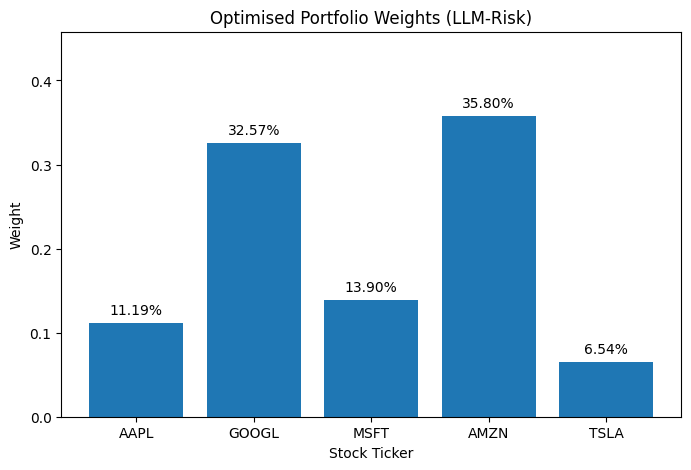

In [91]:
plt.figure(figsize=(8,5))
plt.bar(tickers, optimized_weights)
for i, w in enumerate(optimized_weights):
    plt.text(i, w + 0.01, f"{w:.2%}", ha='center')
plt.title('Optimised Portfolio Weights (LLM-Risk)')
plt.xlabel('Stock Ticker')
plt.ylabel('Weight')
plt.ylim(0, max(optimized_weights) + 0.1)
plt.show()